In [21]:
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

In [22]:
# -------------------------------
# Cargar dataset JSONL
# -------------------------------
def load_jsonl(file_path):
    texts = []
    labels = []
    tipos = []
    origenes = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            texts.append(data["texto"])
            labels.append(data["clase"])
            tipos.append(data["tipo"])
            origenes.append(data["origen"])
    return texts, labels, tipos, origenes

In [23]:
# Ruta del archivo jsonl
file_path = 'capitulos_base_100_completo.jsonl'
texts, labels, tipos, origenes = load_jsonl(file_path)

In [24]:
# -------------------------------
# Métrica simple de cantidad por clase y tipo
# -------------------------------
df_conteo = pd.DataFrame({
    "clase": labels,
    "tipo": tipos
})

conteo = df_conteo.value_counts().reset_index(name='cantidad')

print("\nCantidad de textos por clase y tipo:")
print(conteo)


Cantidad de textos por clase y tipo:
    clase    tipo  cantidad
0      ia  cuento        38
1      ia   libro        34
2  humano   libro        32
3      ia  ensayo        32
4  humano  ensayo        18
5  humano  cuento        18


In [25]:
# -------------------------------
# Cargar modelo BERT y tokenizer
# -------------------------------
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def embed_texts(text_list):
    embeddings = []
    for text in text_list:
        tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**tokens)
        emb = outputs.pooler_output[0].numpy()
        embeddings.append(emb)
    return np.array(embeddings)

X = embed_texts(texts)
y = np.array(labels)

In [26]:
# -------------------------------
# Entrenamiento con K-Fold Cross Validation y Grid Search
# -------------------------------
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
cv_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor F1 macro promedio:", cv_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mejor F1 macro promedio: 0.828499195988677



Reporte de clasificación:
              precision    recall  f1-score   support

      humano       0.85      0.74      0.79        68
          ia       0.84      0.91      0.88       104

    accuracy                           0.84       172
   macro avg       0.84      0.82      0.83       172
weighted avg       0.84      0.84      0.84       172



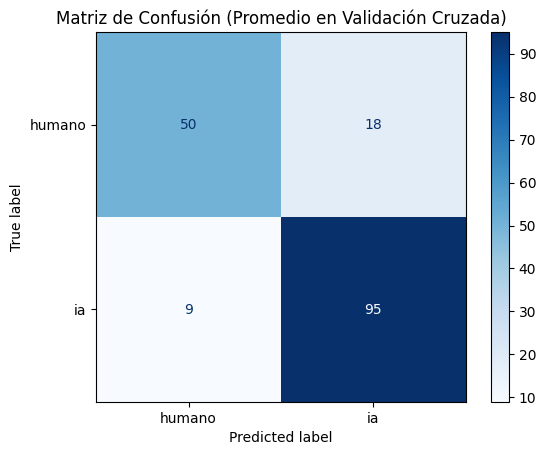

In [27]:
# -------------------------------
# Visualización de métricas y matriz de confusión
# -------------------------------
y_pred = cross_val_predict(best_model, X, y, cv=cv)

print("\nReporte de clasificación:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión (Promedio en Validación Cruzada)")
plt.show()

In [ ]:
# -------------------------------
# Guardar modelo entrenado
# -------------------------------
joblib.dump(best_model, 'modelo_random_forest_entrenado_k_fold.pkl')

In [28]:
import pandas as pd

# Creamos DataFrame con predicción vs realidad
df_resultados = pd.DataFrame({
    "texto": texts,
    "origen": origenes, 
    "etiqueta_real": labels,
    "prediccion": y_pred
})

# Mostramos primeros resultados
df_resultados.head()

,texto,origen,etiqueta_real,prediccion
0,PARTE PRIMERA\nCAPÍTULO PRIMERO\n\nQue trata d...,https://es.wikisource.org/wiki/El_ingenioso_hi...,humano,humano
1,El Señor de los Anillos\n\nJRR Tolkien\n\nPART...,El Señor de los Anillos: La Comunidad del Anil...,humano,ia
2,1\nUNA TERTULIA INESPERADA\nn un agujero en el...,"El Hobbit, J.R.R. Tolkien",humano,humano
3,CAPÍTULO 1\nRobert Langdon despertó con parsim...,"El código Da Vinci, Dan Brown",humano,humano
4,I E\nLlamadme Ismael. Hace unos años —no impor...,"Moby Dick, Herman Melville",humano,humano


In [29]:
# Falsos negativos: humano predicho como IA
falsos_negativos = df_resultados[
    (df_resultados["etiqueta_real"] == "humano") & (df_resultados["prediccion"] == "ia")
]

# Falsos positivos: IA predicha como humano
falsos_positivos = df_resultados[
    (df_resultados["etiqueta_real"] == "ia") & (df_resultados["prediccion"] == "humano")
]

print(f"Falsos negativos: {len(falsos_negativos)}")
print(f"Falsos positivos: {len(falsos_positivos)}")

Falsos negativos: 18
Falsos positivos: 9


In [30]:
# Mostrar primeros falsos negativos
print("FALSOS NEGATIVOS (humanos clasificados como IA):")
for i, fila in falsos_negativos.head(5).iterrows():
    print(f"\nTexto {i}:\n", fila["texto"][:100])  # límite de caracteres para que no colapse la salida

# Mostrar primeros falsos positivos
print("\nFALSOS POSITIVOS (IA clasificadas como humano):")
for i, fila in falsos_positivos.head(5).iterrows():
    print(f"\nTexto {i}:\n", fila["texto"][:100])

FALSOS NEGATIVOS (humanos clasificados como IA):

Texto 1:
 El Señor de los Anillos

JRR Tolkien

PARTE I: La Comunidad del Anillo

PROLOGO
1
De los Hobbits

Es

Texto 6:
 C A P Í T U L O I
DEL DIARIO DE JONATHAN HARKER
Bistritz, 3 de mayo. Salí de Münich a las 8:35 de la

Texto 8:
 Lo absurdo y el suicidio
No hay más que un problema filosófico verdaderamente serio: el suicidio.
Ju

Texto 9:
 El hecho de las aglomeraciones
Hay un hecho que, para bien o para mal, es el más importante en
la vi

Texto 20:
 Nací, por fortuna mía, vagón de primera clase, y mi ejecutoria acredita la reciedumbre y nobleza de 

FALSOS POSITIVOS (IA clasificadas como humano):

Texto 78:
 Capítulo – El relojero de las sombras

En la esquina más gris de Estrasburgo, donde el sol llegaba a

Texto 79:
 Capítulo – La simetría del eco

I. EL MAPA SIN LÍMITES

Cuando Ada despertó en la sala blanca, no re

Texto 96:
 Título – El hombre que pesaba palabras

En un pueblo escondido entre montañas, vivía un hombre que s

T

Análisis cualitativo real de errores
Falsos negativos (humanos clasificados como IA):

El primer texto es de El Señor de los Anillos, con un tono muy narrativo, estructurado, formal, y sin errores.

Tiene una introducción temática clara, una organización en capítulos, y una coherencia muy pulida.

Esto hace que, aunque sea humano, el modelo lo asocie a los textos IA mejor generados, ya que la IA tiende a producir textos así cuando se le pide algo largo y bien escrito.

Falsos positivos (IA clasificadas como humanos):

En el fragmento que aparece abajo (que parece IA), se describen imágenes sensoriales, con metáforas como “el lamento distante de las gaviotas” o “una sirena de ojos verdes esmeralda”.

Eso sugiere un intento deliberado de emular estilo literario humano, cosa que modelos como ChatGPT hacen bastante bien.

Conclusión basada en datos
Puedes afirmar que:

En los errores detectados, hay un patrón claro: los textos humanos que presentan una estructura formal y narrativa refinada tienden a ser clasificados como IA, mientras que las IAs que imitan bien el estilo narrativo humano con descripciones y tono literario pueden ser confundidas con humanos.

In [31]:
# Concatenamos ambos grupos de error en un solo DataFrame
errores = pd.concat([
    falsos_negativos.assign(tipo_error="falso_negativo"),
    falsos_positivos.assign(tipo_error="falso_positivo")
])

# Reordenamos columnas para mayor claridad
errores = errores[["tipo_error", "etiqueta_real", "prediccion", "texto"]]

# Ordenamos por tipo de error para visualización agrupada
errores = errores.sort_values(by="tipo_error").reset_index(drop=True)

# Mostramos todos los errores (puedes poner .head() para limitar si prefieres)
errores

,tipo_error,etiqueta_real,prediccion,texto
0,falso_negativo,humano,ia,El Señor de los Anillos\n\nJRR Tolkien\n\nPART...
1,falso_negativo,humano,ia,"CAPÍTULO PRIMERO\n\nMis padres, el lugar de mi..."
2,falso_negativo,humano,ia,CAPÍTULO PRIMERO\n¡Hombre al agua!— El Tajo.— ...
3,falso_negativo,humano,ia,(Cuento chino)\n\n\nEL HEDIONDO POZO SINIESTRO...
4,falso_negativo,humano,ia,-Este es un minero de veras -me decía el mayor...
5,falso_negativo,humano,ia,"Lector mío, seas quien fueres, no te espero mu..."
6,falso_negativo,humano,ia,"La prensa mitrista llama ""descamisados"" a todo..."
7,falso_negativo,humano,ia,1\nHABLEMOS DE LITERATURA.\n\n\nLa literatura ...
8,falso_negativo,humano,ia,"No hace mucho, en una conferencia, sentí que e..."
9,falso_negativo,humano,ia,Una traducción —cuando buena— es a su original...


In [32]:
# Añadir columna con longitud de texto (número de palabras)
errores["longitud_palabras"] = errores["texto"].apply(lambda x: len(x.split()))

In [33]:
# Estadísticas de longitud por tipo de error
longitud_stats = errores.groupby("tipo_error")["longitud_palabras"].describe()
print(longitud_stats)

                count         mean          std    min     25%     50%  \
tipo_error                                                               
falso_negativo   18.0  2643.277778  1828.040217  705.0  1329.0  2271.5   
falso_positivo    9.0   584.555556   236.821194  273.0   325.0   638.0   

                    75%     max  
tipo_error                       
falso_negativo  3477.75  7527.0  
falso_positivo   770.00   899.0  


In [34]:
import re
from collections import Counter

# Función para contar palabras más comunes en un texto
def top_10_palabras(texto):
    palabras = re.findall(r'\b\w+\b', texto.lower())
    contador = Counter(palabras)
    top = [palabra for palabra, _ in contador.most_common(10)]
    return ", ".join(top)

# Añadir columnas al DataFrame de errores
errores["longitud_palabras"] = errores["texto"].apply(lambda x: len(x.split()))
errores["top_palabras"] = errores["texto"].apply(top_10_palabras)

# Mostrar resultado
errores = errores[["tipo_error", "etiqueta_real", "prediccion", "texto", "longitud_palabras", "top_palabras"]]
errores

,tipo_error,etiqueta_real,prediccion,texto,longitud_palabras,top_palabras
0,falso_negativo,humano,ia,El Señor de los Anillos\n\nJRR Tolkien\n\nPART...,3521,"de, los, y, en, la, el, que, las, a, se"
1,falso_negativo,humano,ia,"CAPÍTULO PRIMERO\n\nMis padres, el lugar de mi...",1678,"de, la, y, en, el, los, a, que, mi, por"
2,falso_negativo,humano,ia,CAPÍTULO PRIMERO\n¡Hombre al agua!— El Tajo.— ...,4072,"de, la, que, en, y, a, el, los, las, se"
3,falso_negativo,humano,ia,(Cuento chino)\n\n\nEL HEDIONDO POZO SINIESTRO...,1216,"de, el, y, los, que, en, a, la, siké, las"
4,falso_negativo,humano,ia,-Este es un minero de veras -me decía el mayor...,2223,"de, la, el, y, que, me, no, en, a, un"
5,falso_negativo,humano,ia,"Lector mío, seas quien fueres, no te espero mu...",1178,"que, de, en, no, la, el, a, los, y, porque"
6,falso_negativo,humano,ia,"La prensa mitrista llama ""descamisados"" a todo...",705,"que, los, de, a, la, y, descamisados, su, en, no"
7,falso_negativo,humano,ia,1\nHABLEMOS DE LITERATURA.\n\n\nLa literatura ...,1668,"de, la, el, y, en, que, a, un, o, por"
8,falso_negativo,humano,ia,"No hace mucho, en una conferencia, sentí que e...",7527,"de, que, la, el, y, en, no, a, los, un"
9,falso_negativo,humano,ia,Una traducción —cuando buena— es a su original...,2488,"de, la, que, en, y, el, su, a, del, por"


In [35]:
# Añadir las columnas 'tipo' y 'origen' al DataFrame original
df_resultados["tipo"] = tipos
df_resultados["origen"] = origenes  # asegúrate de que esta lista también está cargada del JSONL original

# Volver a generar los errores con las nuevas columnas
falsos_negativos = df_resultados[
    (df_resultados["etiqueta_real"] == "humano") & (df_resultados["prediccion"] == "ia")
].assign(tipo_error="falso_negativo")

falsos_positivos = df_resultados[
    (df_resultados["etiqueta_real"] == "ia") & (df_resultados["prediccion"] == "humano")
].assign(tipo_error="falso_positivo")

import re
from collections import Counter

def top_10_palabras(texto):
    palabras = re.findall(r'\b\w+\b', texto.lower())
    contador = Counter(palabras)
    top = [palabra for palabra, _ in contador.most_common(10)]
    return ", ".join(top)

# Concatenar y enriquecer
errores = pd.concat([falsos_negativos, falsos_positivos])
errores["longitud_palabras"] = errores["texto"].apply(lambda x: len(x.split()))
errores["top_palabras"] = errores["texto"].apply(top_10_palabras)

# Reordenar columnas
errores = errores[
    ["tipo_error", "etiqueta_real", "prediccion", "tipo", "origen", "texto", "longitud_palabras", "top_palabras"]
].reset_index(drop=True)

# Mostrar
errores

,tipo_error,etiqueta_real,prediccion,tipo,origen,texto,longitud_palabras,top_palabras
0,falso_negativo,humano,ia,libro,El Señor de los Anillos: La Comunidad del Anil...,El Señor de los Anillos\n\nJRR Tolkien\n\nPART...,3521,"de, los, y, en, la, el, que, las, a, se"
1,falso_negativo,humano,ia,libro,"Drácula, Bram Stoker",C A P Í T U L O I\nDEL DIARIO DE JONATHAN HARK...,5900,"de, que, y, la, a, el, en, los, se, un"
2,falso_negativo,humano,ia,ensayo,El mito de Sísifo – Albert Camus,Lo absurdo y el suicidio\nNo hay más que un pr...,2134,"la, que, de, el, a, en, y, se, es, no"
3,falso_negativo,humano,ia,ensayo,La rebelión de las masas – José Ortega y Gasset,El hecho de las aglomeraciones\nHay un hecho q...,2330,"de, la, que, en, el, y, los, es, no, a"
4,falso_negativo,humano,ia,libro,https://www.gutenberg.org/cache/epub/62840/pg6...,"Nací, por fortuna mía, vagón de primera clase,...",2320,"de, y, la, los, que, me, el, a, mi, en"
5,falso_negativo,humano,ia,libro,https://es.wikisource.org/wiki/Orgullo_y_preju...,ORGULLO Y PREJUICIO\nCAPITULO PRIMERO\nEs verd...,766,"de, que, a, no, la, y, en, lo, el, su"
6,falso_negativo,humano,ia,ensayo,https://es.wikisource.org/wiki/A_cada_paso_un_...,"Antes de hablar de El Caballero, una de las má...",715,"de, que, en, y, la, las, el, a, más, del"
7,falso_negativo,humano,ia,ensayo,https://es.wikisource.org/wiki/De_la_naturalez...,Capítulo I\nNo seré yo quien ponga en duda el ...,3790,"de, y, que, la, en, el, no, los, a, lo"
8,falso_negativo,humano,ia,ensayo,https://es.wikisource.org/wiki/La_Celestina:_R...,La Celestina. - Razones para tratar de esta ob...,3348,"de, la, y, que, en, el, a, los, no, del"
9,falso_negativo,humano,ia,ensayo,https://es.wikisource.org/wiki/La_vida_sin_fun...,"No hace mucho, en una conferencia, sentí que e...",7527,"de, que, la, el, y, en, no, a, los, un"


🧠 FALSOS NEGATIVOS (humanos predichos como IA)
Tipo predominante: ensayo y libro, muchos de ellos extraídos de fuentes como Wikisource o Gutenberg (textos clásicos y bien redactados).

Longitud: mayoritariamente textos largos (>2000 palabras, algunos >5000).

Top palabras: muchas preposiciones y conectores frecuentes (de, que, en, la, el…), lo que diluye el vocabulario distintivo.

Estilo general: textos serios, argumentativos o literarios, con vocabulario cuidado, lo cual puede asemejarse al estilo "estándar" que generan los modelos IA.

🤖 FALSOS POSITIVOS (IA predicha como humano)
Origen: modelos como ChatGPT4o, Gemini Flash y Copilot Fast.

Tipo de texto: mayoría son cuentos o capítulos simulados de libro.

Longitud: más cortos (varios con menos de 900 palabras, incluso uno de 273).

Top palabras: se cuelan algunas más significativas o narrativas (e.g. reloj, samuel, cada, tiempo…), lo que sugiere un estilo más personalizado o narrativo.

🔎 Conclusión operativa
Aunque no hay reglas claras, sí puedes extraer esto:

Al revisar los errores, no se aprecia un patrón estrictamente determinista, pero se observan ciertos indicios:

Los textos humanos más largos, formales y bien estructurados tienden a confundirse con IA.

Las IAs que generan narrativa más personalizada o informal engañan mejor al clasificador.

El vocabulario más frecuente en los errores es funcional (de, que, en...), lo que refuerza la idea de que los errores no dependen de palabras concretas, sino del conjunto estilístico general.

In [36]:
conteo = errores.groupby(["etiqueta_real", "tipo"]).size().reset_index(name="cantidad")
print(conteo)

  etiqueta_real    tipo  cantidad
0        humano  cuento         2
1        humano  ensayo        10
2        humano   libro         6
3            ia  cuento         4
4            ia   libro         5


In [37]:
conteo_total = df_resultados.groupby(["etiqueta_real", "tipo"]).size().reset_index(name="cantidad")
print(conteo_total)

  etiqueta_real    tipo  cantidad
0        humano  cuento        18
1        humano  ensayo        18
2        humano   libro        32
3            ia  cuento        38
4            ia  ensayo        32
5            ia   libro        34


In [38]:
# Conteo total por etiqueta y tipo
totales = df_resultados.groupby(["etiqueta_real", "tipo"]).size().reset_index(name="total")

# Conteo de errores por etiqueta y tipo
errores_conteo = errores.groupby(["etiqueta_real", "tipo"]).size().reset_index(name="errores")

# Unimos ambos conteos
resumen = pd.merge(totales, errores_conteo, on=["etiqueta_real", "tipo"], how="left")
resumen["errores"] = resumen["errores"].fillna(0).astype(int)

# Cálculo de porcentajes
resumen["% acierto"] = ((resumen["total"] - resumen["errores"]) / resumen["total"] * 100).round(2)
resumen["% fallo"] = (resumen["errores"] / resumen["total"] * 100).round(2)

# Orden final
resumen = resumen[["etiqueta_real", "tipo", "total", "errores", "% acierto", "% fallo"]]

# Mostrar
print(resumen)

  etiqueta_real    tipo  total  errores  % acierto  % fallo
0        humano  cuento     18        2      88.89    11.11
1        humano  ensayo     18       10      44.44    55.56
2        humano   libro     32        6      81.25    18.75
3            ia  cuento     38        4      89.47    10.53
4            ia  ensayo     32        0     100.00     0.00
5            ia   libro     34        5      85.29    14.71


🧠 Observaciones clave del comportamiento del modelo:
Los textos humanos tipo ensayo son los más difíciles de clasificar correctamente.

55.56% de fallos.

Esto puede deberse a que su tono formal, argumentativo y bien estructurado se asemeja al de los textos generados por IA, especialmente los de ChatGPT o Gemini.

Los cuentos humanos e IA se clasifican bastante bien.

Humanos (cuento): 88.89% de acierto.

IA (cuento): 89.47% de acierto.

Esto sugiere que el estilo narrativo, la estructura o el vocabulario de este tipo de texto permite al modelo diferenciar mejor entre IA y humano.

Los ensayos IA fueron clasificados perfectamente (100% de acierto).

Probablemente porque el modelo ya reconoce patrones típicos en textos IA con estilo formal y estructurado.

Libros: aceptable pero más equilibrado.

Humanos (libro): 81.25%

IA (libro): 85.29%

Aquí parece que hay más ambigüedad, quizá por la variedad de estilos dentro de la categoría "libro".

🧩 Conclusión real que puedes usar
El análisis por clase y tipo muestra que el modelo no falla de forma aleatoria.
El mayor porcentaje de errores se da en textos humanos del tipo ensayo, donde el lenguaje formal y la estructura ordenada pueden hacerlos parecer generados por IA.
En cambio, los textos IA tipo ensayo fueron detectados sin errores, lo que refuerza la idea de que ciertos patrones estilísticos están bien interiorizados por el modelo.

C:\Users\ddiaz\AppData\Local\Temp\ipykernel_16596\2292218170.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="Tipo", y="Porcentaje", hue="Métrica", palette="Blues", ci=None)


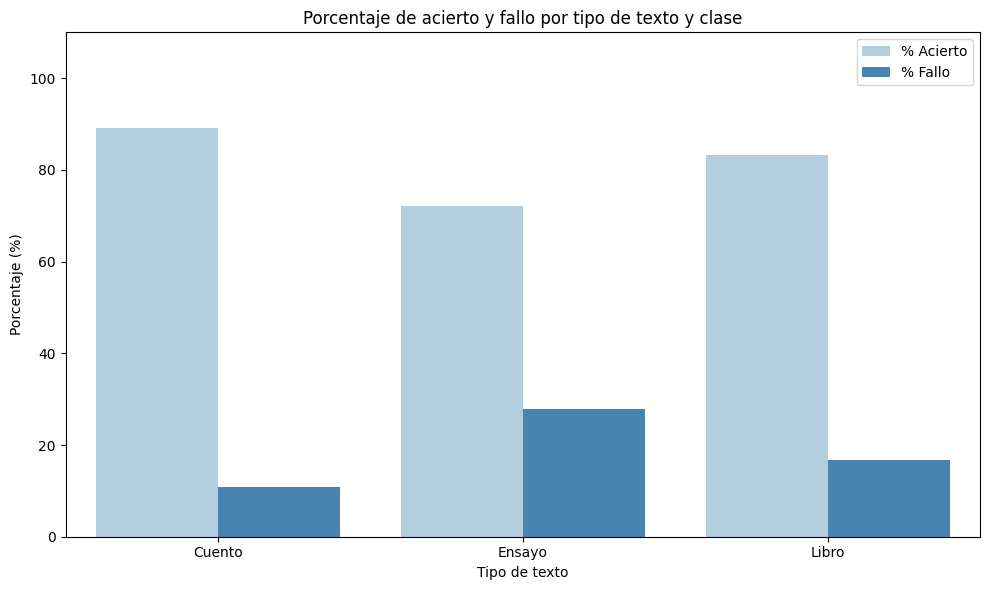

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Datos directamente de la tabla final
data = {
    "Clase": ["Humano", "Humano", "Humano", "IA", "IA", "IA"],
    "Tipo": ["Cuento", "Ensayo", "Libro", "Cuento", "Ensayo", "Libro"],
    "% Acierto": [88.89, 44.44, 81.25, 89.47, 100.0, 85.29],
    "% Fallo": [11.11, 55.56, 18.75, 10.53, 0.0, 14.71]
}

df_plot = pd.DataFrame(data)

# Convertir de wide a long format para gráfico con seaborn
df_melted = df_plot.melt(id_vars=["Clase", "Tipo"], value_vars=["% Acierto", "% Fallo"],
                         var_name="Métrica", value_name="Porcentaje")

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Tipo", y="Porcentaje", hue="Métrica", palette="Blues", ci=None)

# Añadir detalles
plt.title("Porcentaje de acierto y fallo por tipo de texto y clase")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Tipo de texto")
plt.ylim(0, 110)
plt.legend(title="")

# Opcional: mostrar por clase separada (puedes descomentar si prefieres dividir)
# g = sns.catplot(..., col="Clase")

plt.tight_layout()
plt.show()

C:\Users\ddiaz\AppData\Local\Temp\ipykernel_16596\2015986208.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="Grupo", y="Porcentaje", hue="Métrica", palette="Blues", ci=None)


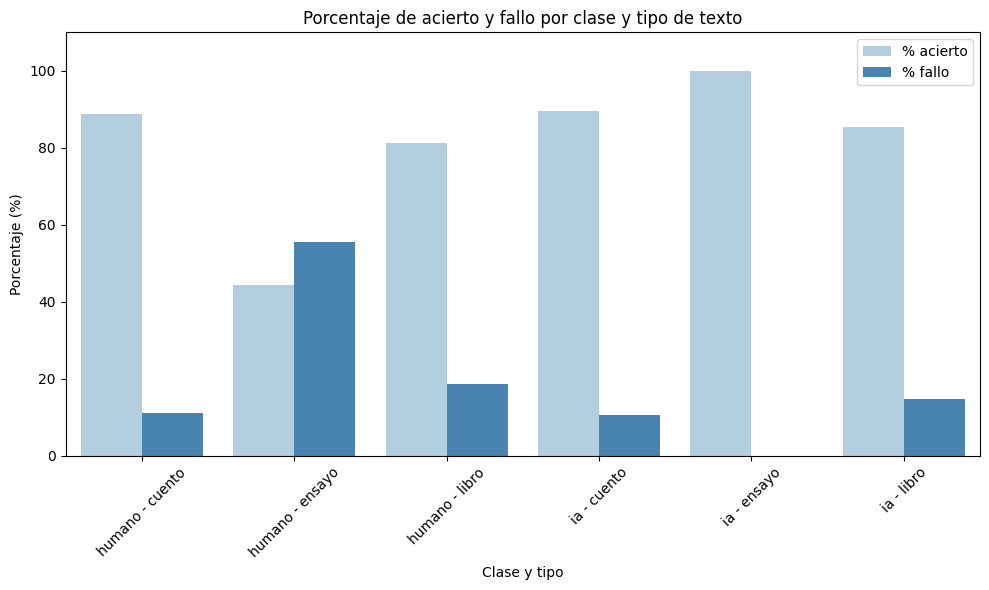

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertimos el DataFrame resumen a formato largo
df_melted = resumen.melt(id_vars=["etiqueta_real", "tipo"], 
                         value_vars=["% acierto", "% fallo"],
                         var_name="Métrica", value_name="Porcentaje")

# Concatenamos clase y tipo para mejor visualización en eje X
df_melted["Grupo"] = df_melted["etiqueta_real"] + " - " + df_melted["tipo"]

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Grupo", y="Porcentaje", hue="Métrica", palette="Blues", ci=None)

plt.title("Porcentaje de acierto y fallo por clase y tipo de texto")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase y tipo")
plt.xticks(rotation=45)
plt.ylim(0, 110)
plt.legend(title="")

plt.tight_layout()
plt.show()

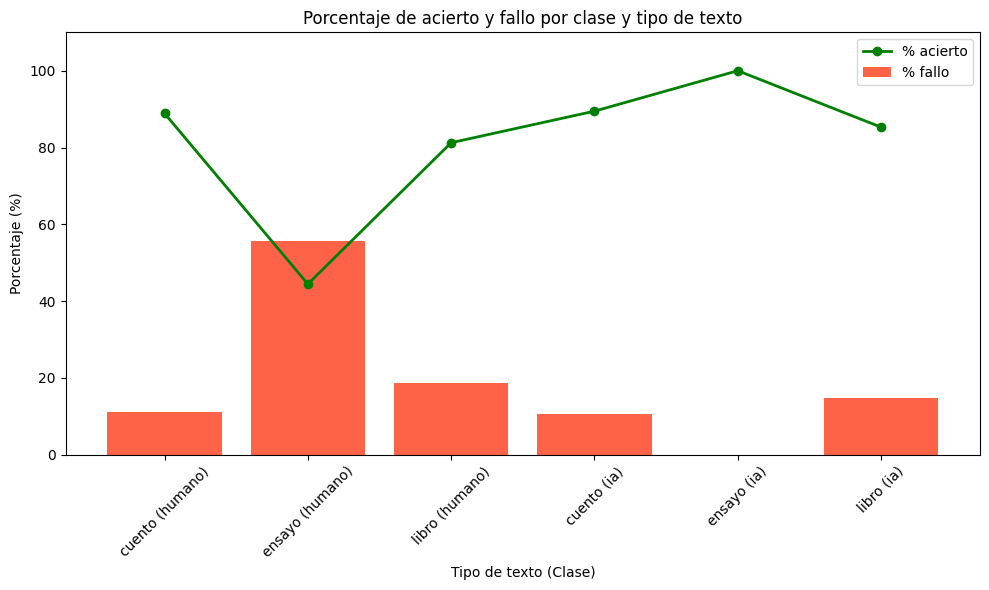

In [41]:
import matplotlib.pyplot as plt

# Orden personalizado para que se vean en orden lógico
orden = resumen.sort_values(by=["etiqueta_real", "tipo"])["tipo"] + " (" + resumen["etiqueta_real"] + ")"
etiquetas = orden.tolist()

# Datos para graficar
fallos = resumen["% fallo"].tolist()
aciertos = resumen["% acierto"].tolist()

# Crear figura
plt.figure(figsize=(10, 6))

# Barras rojas (fallos)
plt.bar(etiquetas, fallos, color="tomato", label="% fallo")

# Línea verde (aciertos)
plt.plot(etiquetas, aciertos, color="green", marker="o", linewidth=2, label="% acierto")

# Estética
plt.title("Porcentaje de acierto y fallo por clase y tipo de texto")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Tipo de texto (Clase)")
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

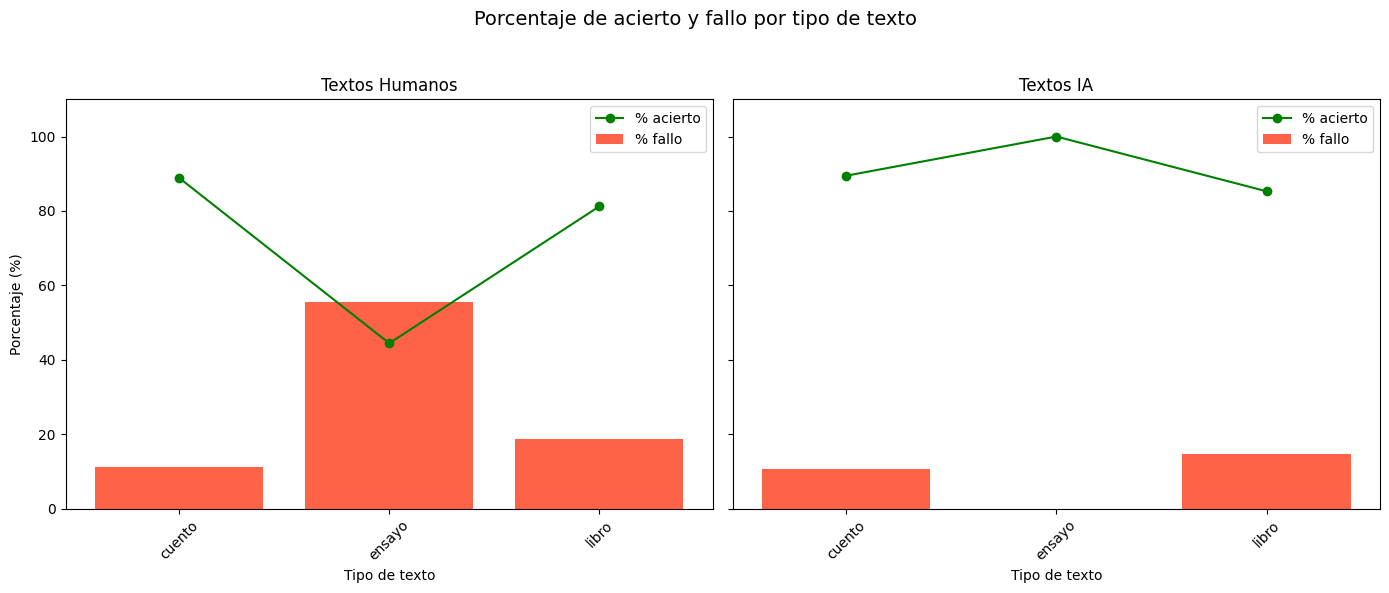

In [42]:
import matplotlib.pyplot as plt

# Separar humanos e IA
res_humanos = resumen[resumen["etiqueta_real"] == "humano"].copy()
res_ia = resumen[resumen["etiqueta_real"] == "ia"].copy()

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Gráfico para humanos ---
axes[0].bar(res_humanos["tipo"], res_humanos["% fallo"], color="tomato", label="% fallo")
axes[0].plot(res_humanos["tipo"], res_humanos["% acierto"], color="green", marker="o", label="% acierto")
axes[0].set_title("Textos Humanos")
axes[0].set_xlabel("Tipo de texto")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].set_ylim(0, 110)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# --- Gráfico para IA ---
axes[1].bar(res_ia["tipo"], res_ia["% fallo"], color="tomato", label="% fallo")
axes[1].plot(res_ia["tipo"], res_ia["% acierto"], color="green", marker="o", label="% acierto")
axes[1].set_title("Textos IA")
axes[1].set_xlabel("Tipo de texto")
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Porcentaje de acierto y fallo por tipo de texto", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

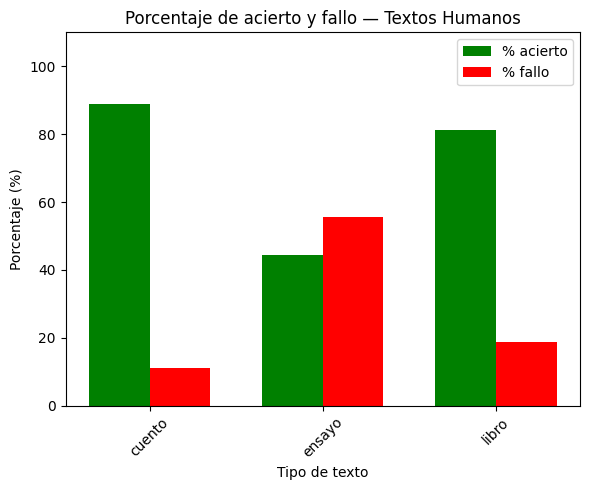

In [43]:
import matplotlib.pyplot as plt

# Filtrar humanos
res_humanos = resumen[resumen["etiqueta_real"] == "humano"].copy()

# Configurar colores exactos
color_acierto = (0, 128/255, 0)   # Verde oscuro
color_fallo = (1, 0, 0)           # Rojo puro (RGB 256, 0, 0)

# Crear gráfico
plt.figure(figsize=(6, 5))
bar_width = 0.35
x = range(len(res_humanos))

# Dibujar barras
plt.bar([i - bar_width/2 for i in x], res_humanos["% acierto"], width=bar_width, color=color_acierto, label="% acierto")
plt.bar([i + bar_width/2 for i in x], res_humanos["% fallo"], width=bar_width, color=color_fallo, label="% fallo")

# Etiquetas y formato
plt.title("Porcentaje de acierto y fallo — Textos Humanos")
plt.xlabel("Tipo de texto")
plt.ylabel("Porcentaje (%)")
plt.xticks(ticks=x, labels=res_humanos["tipo"], rotation=45)
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()
plt.show()

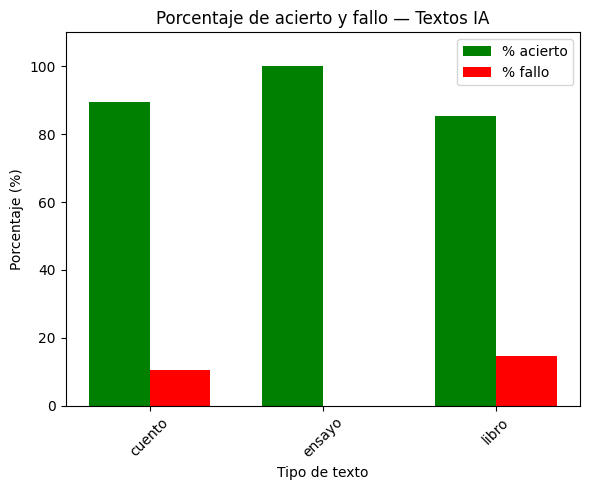

In [44]:
# Filtrar IA
res_ia = resumen[resumen["etiqueta_real"] == "ia"].copy()

# Crear gráfico
plt.figure(figsize=(6, 5))
bar_width = 0.35
x = range(len(res_ia))

# Dibujar barras
plt.bar([i - bar_width/2 for i in x], res_ia["% acierto"], width=bar_width, color=color_acierto, label="% acierto")
plt.bar([i + bar_width/2 for i in x], res_ia["% fallo"], width=bar_width, color=color_fallo, label="% fallo")

# Etiquetas y formato
plt.title("Porcentaje de acierto y fallo — Textos IA")
plt.xlabel("Tipo de texto")
plt.ylabel("Porcentaje (%)")
plt.xticks(ticks=x, labels=res_ia["tipo"], rotation=45)
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()
plt.show()